# Libraries

In [57]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import missingno as msno #check 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler #check 
from sklearn.feature_extraction.text import TfidfVectorizer #check 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack # check
import concurrent.futures
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #check
import xgboost as xgb #check
import numpy as np
import nltk
nltk.download('opinion_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import opinion_lexicon, stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\ejfor\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejfor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ejfor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

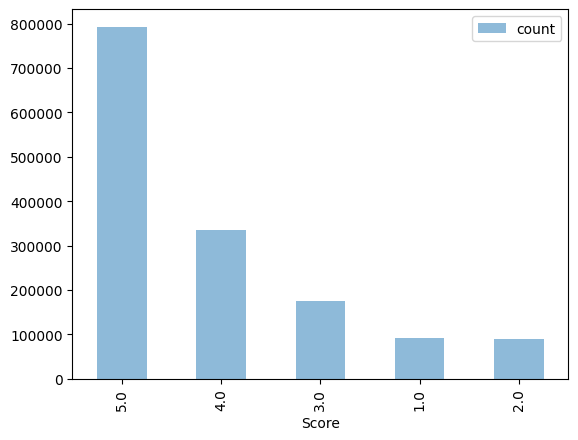


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
89678


In [ ]:
# trainingSet = pd.read_csv("train copy.csv").sample(n=10000, random_state=1)
trainingSet = pd.read_csv("data/train.csv")
# trainingSet = pd.read_csv("train copy.csv")
testingSet = pd.read_csv("data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

min_count = trainingSet['Score'].value_counts().min()
print(min_count)
# df_balanced = trainingSet.groupby('Score').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
# df_balanced = df_balanced.sample(n=10000, random_state=1).reset_index(drop=True)
# print(df_balanced)
# df_balanced['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
# plt.show()


# split train adn submission first and then take smaller train part (like 10000) adn then run fit and save it to a variable and then run 
#trainsform on the smaller train and the take that and transform it to the submisssion part 
# try with one feature at a time and then add up to all of them 
# create apply methods for each of the features and call that when transforming to the submission function 

## Understanding Data

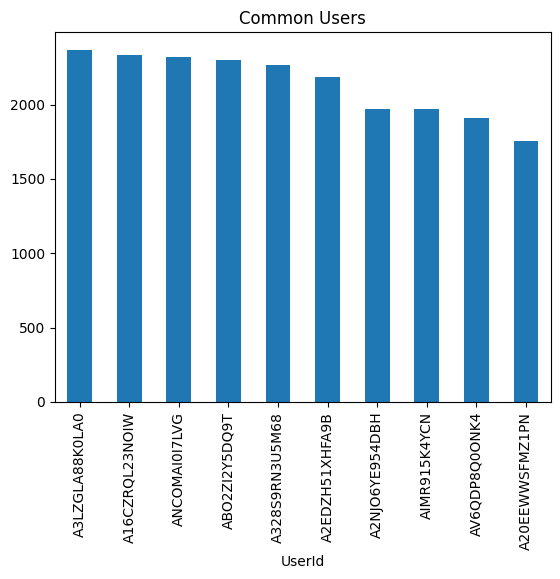

Unique Users 123960


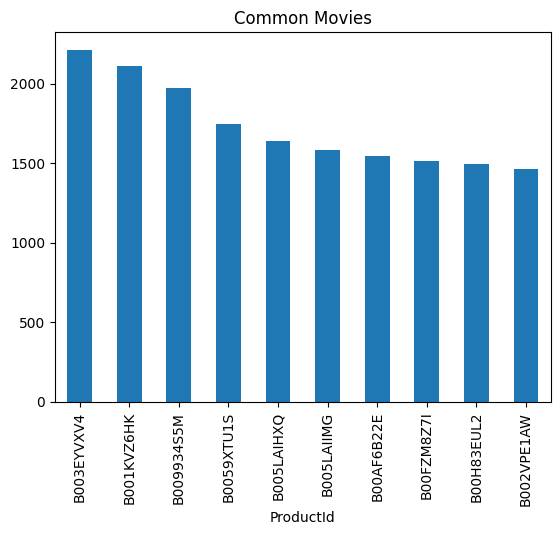

Unique movies 50052


NameError: name 'df_balanced' is not defined

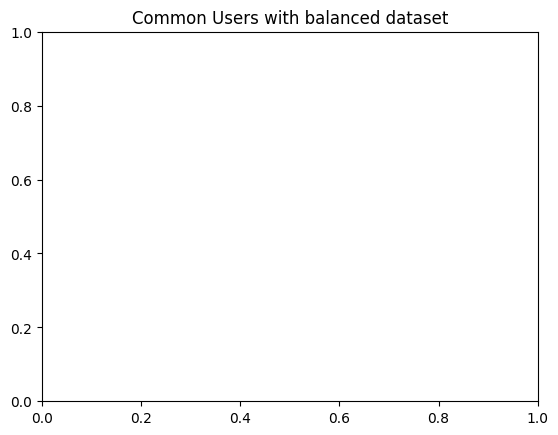

In [ ]:
plt.figure()
plt.title("Common Users")
trainingSet['UserId'].value_counts(sort=True).nlargest(10).plot.bar()
plt.show()
unique_users = trainingSet['UserId'].nunique()
print(f"Unique Users {unique_users}")

plt.figure()
plt.title('Common Movies')
trainingSet['ProductId'].value_counts(sort=True).nlargest(10).plot.bar()
plt.show()
unique_movies = trainingSet['ProductId'].nunique()
print(f"Unique movies {unique_movies}")


/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

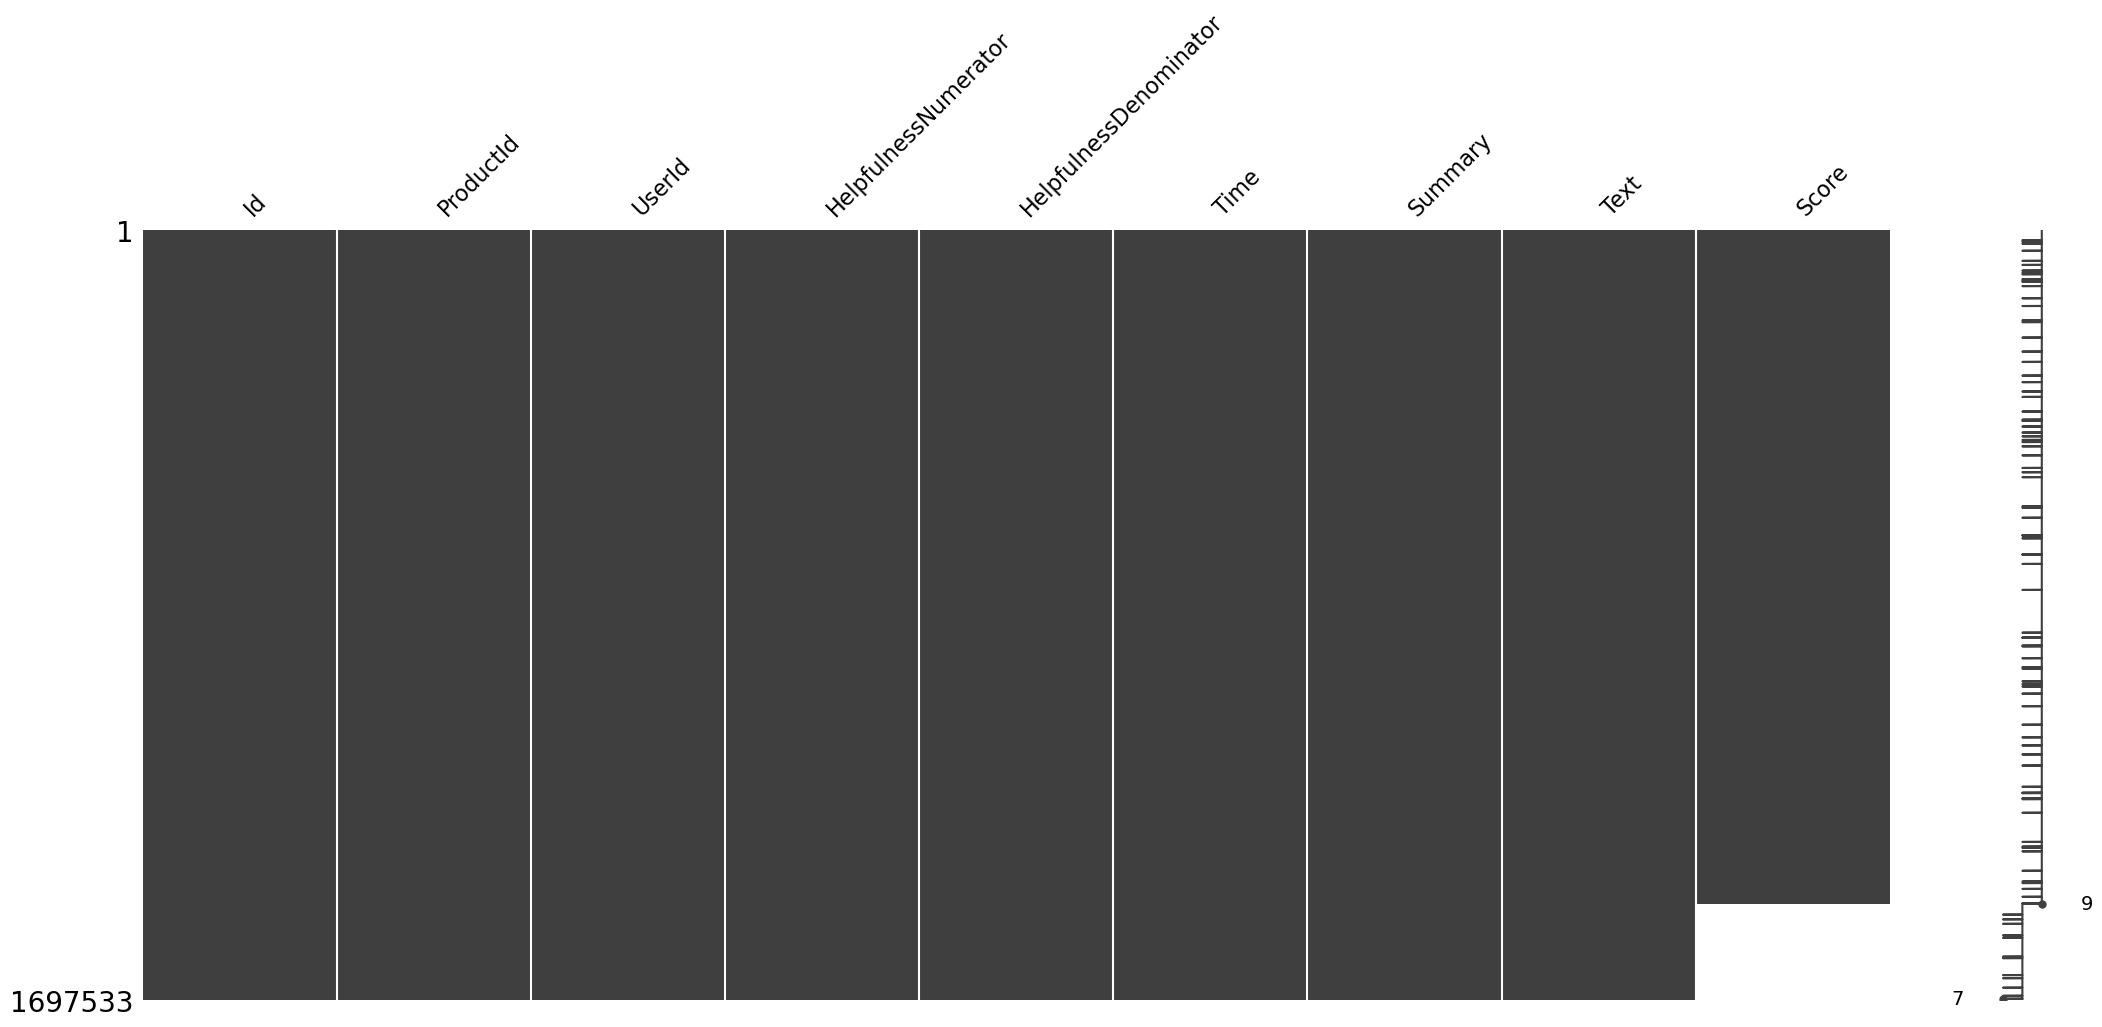

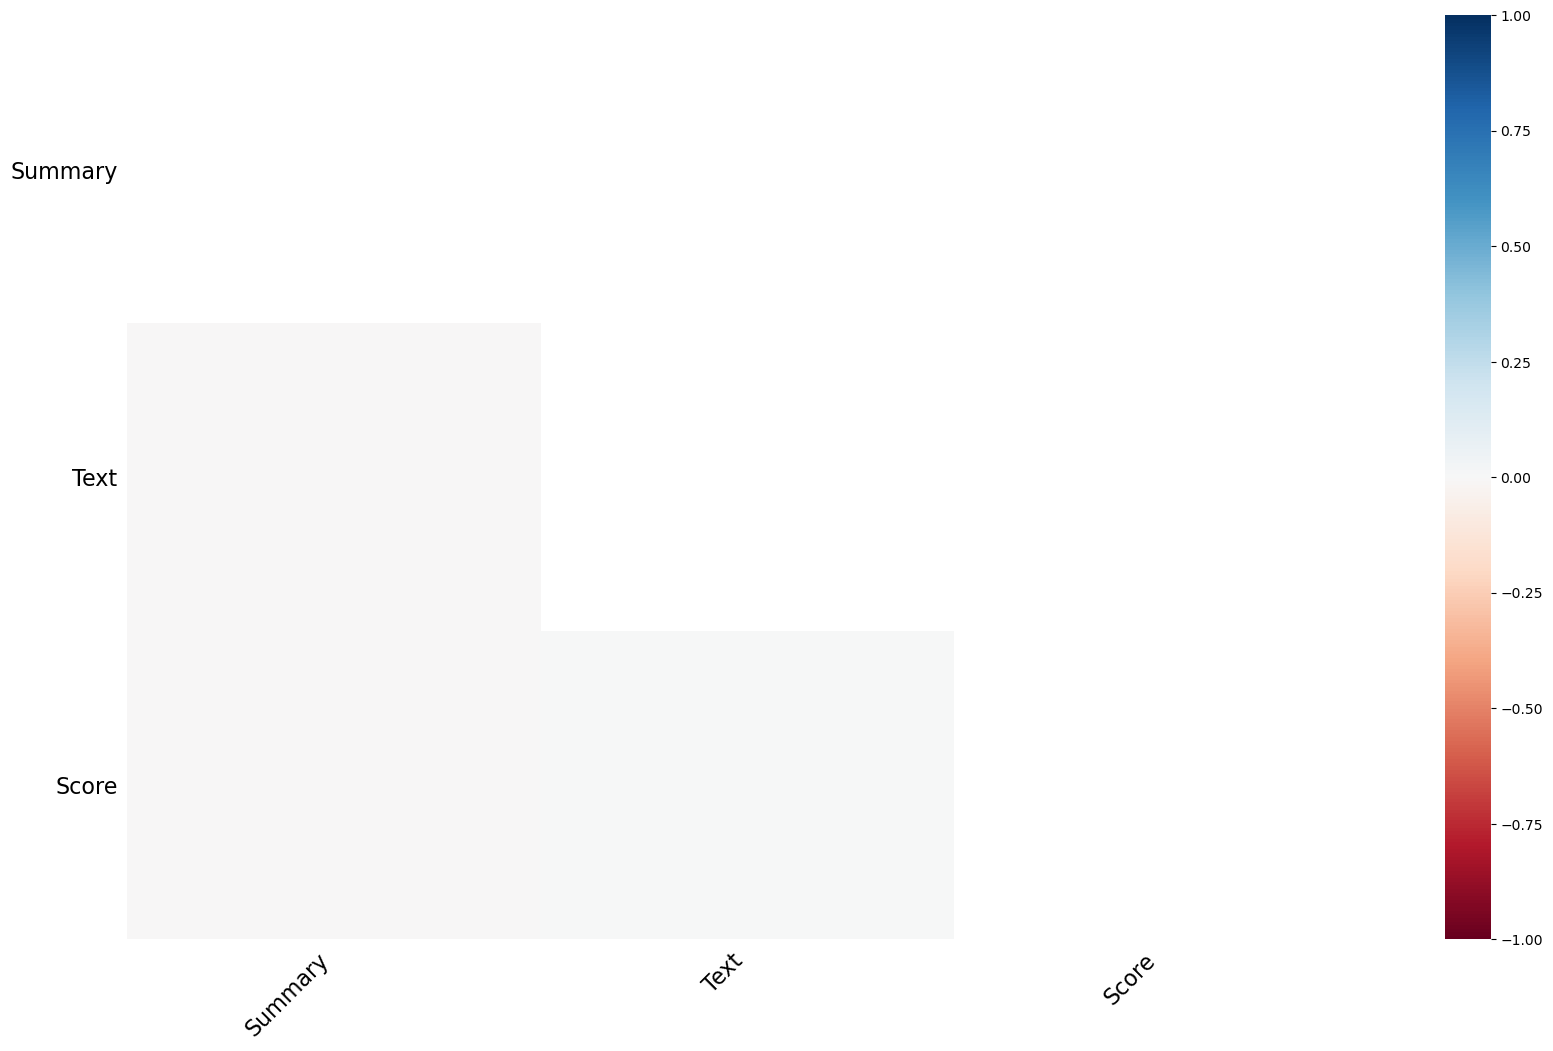

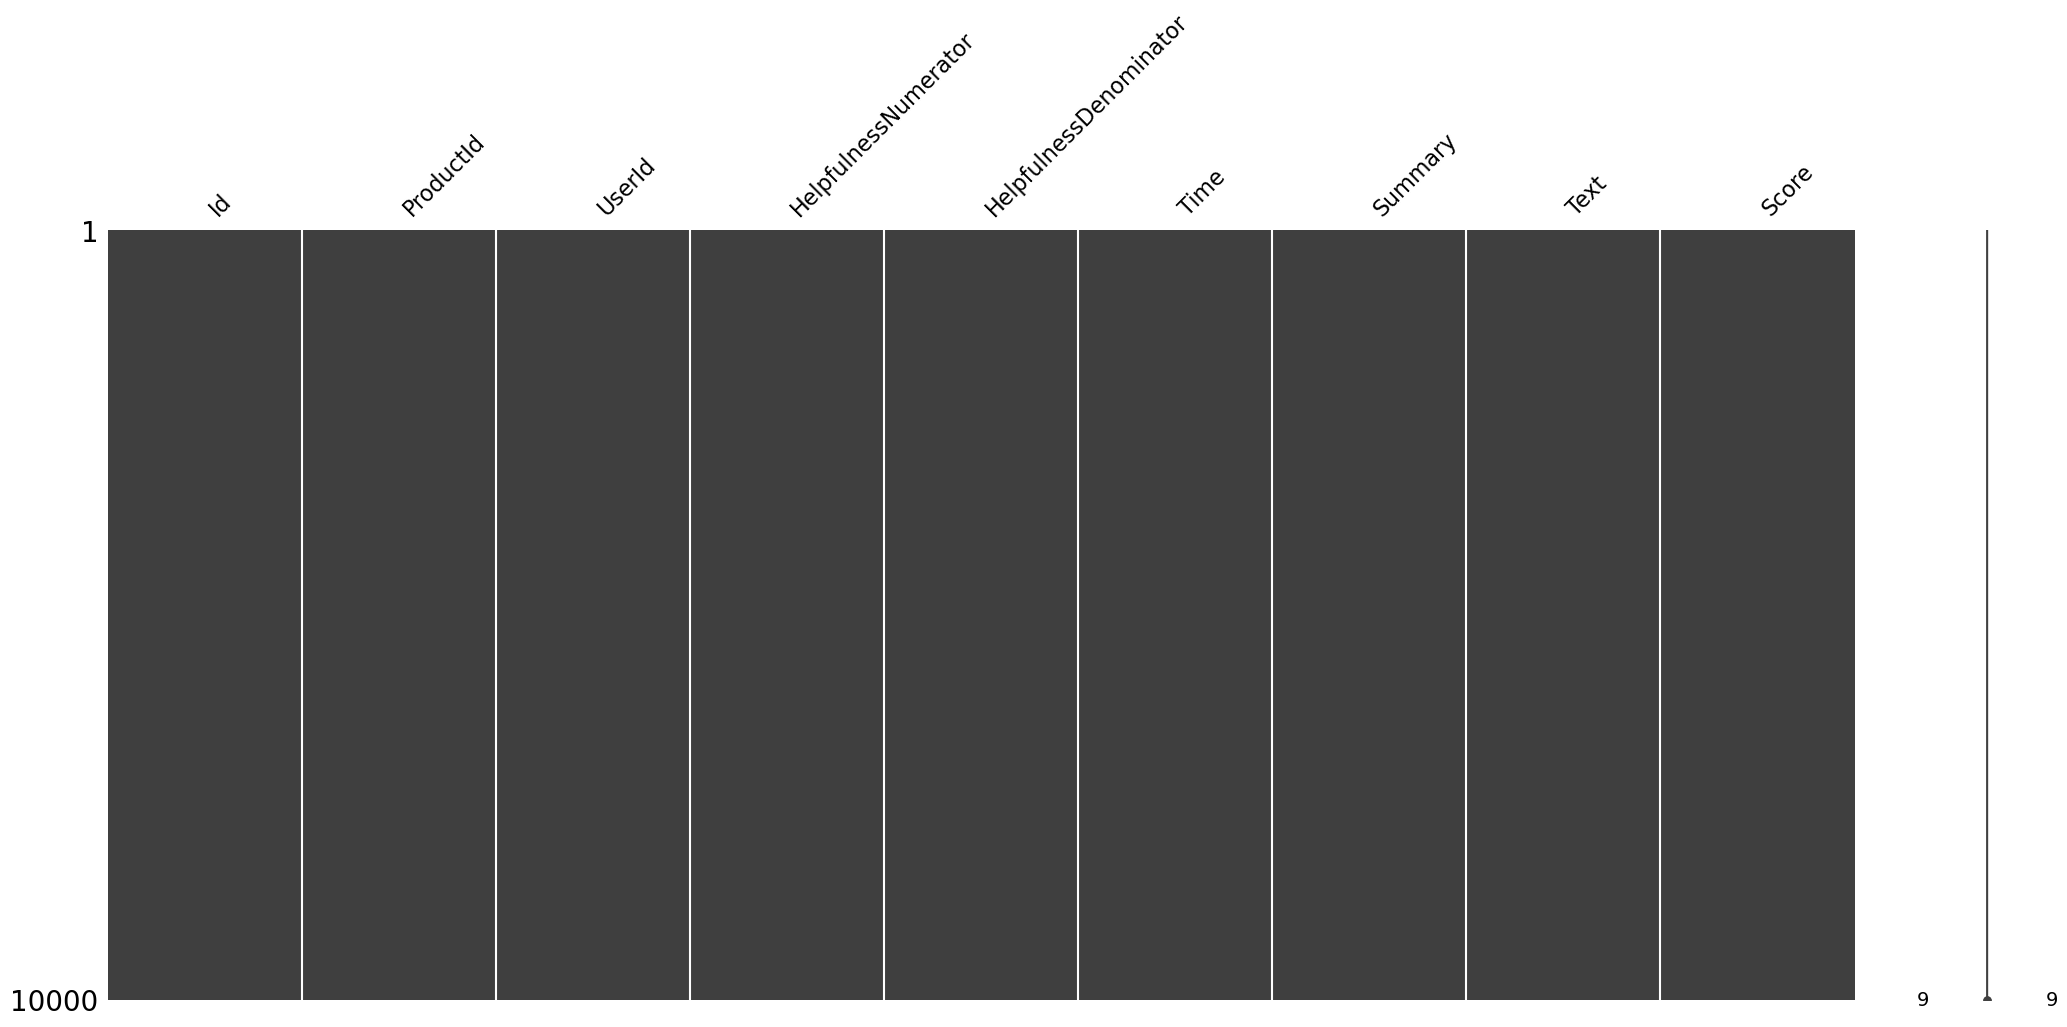

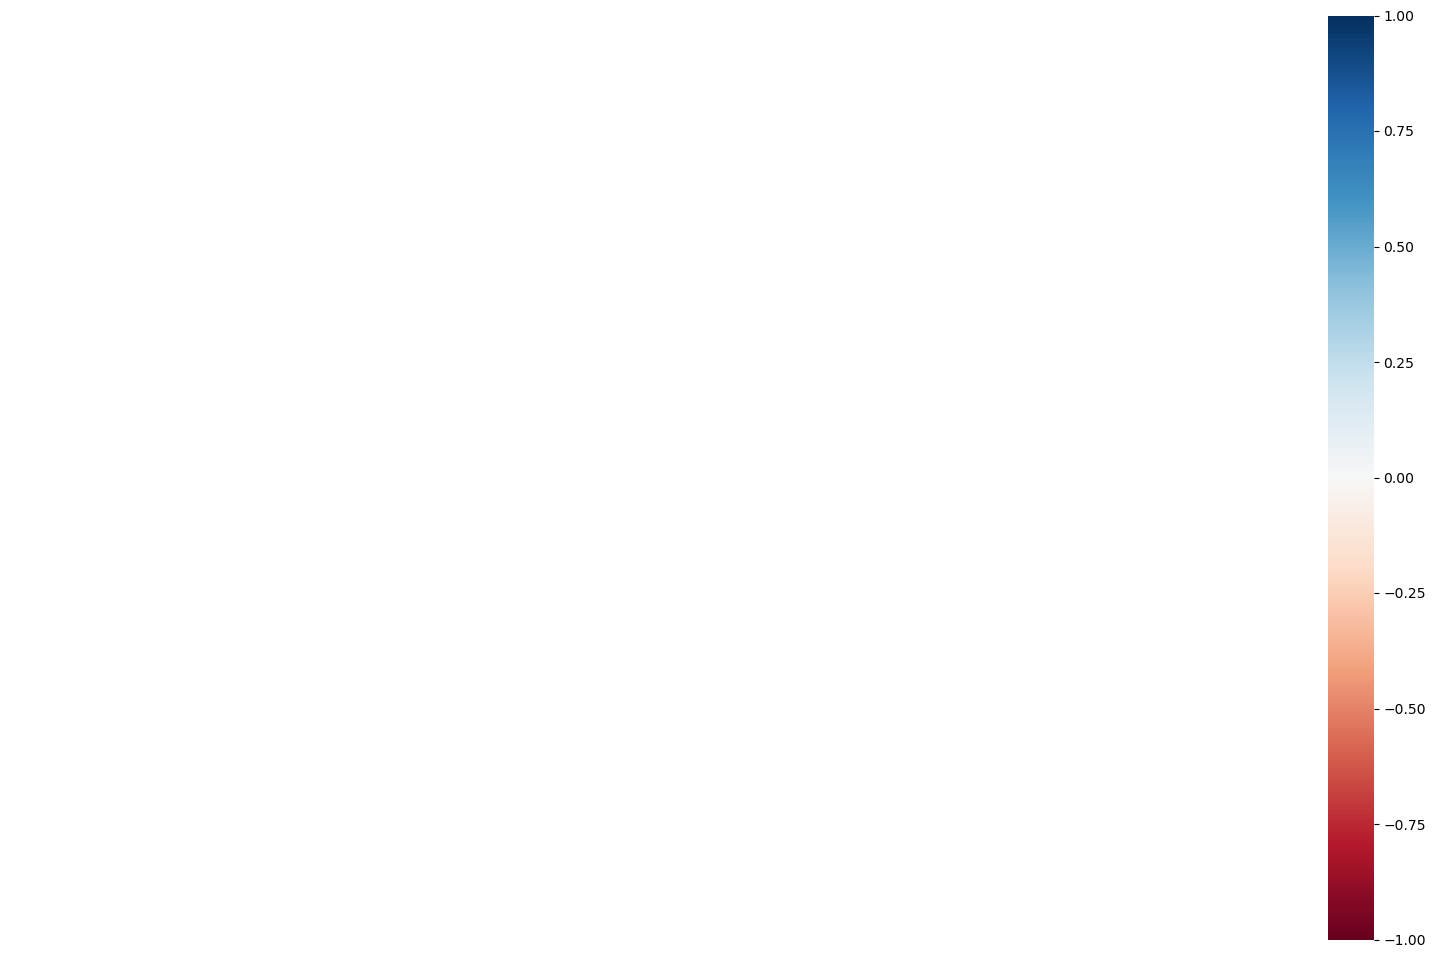

In [ ]:
msno.matrix(trainingSet)
msno.heatmap(trainingSet)

# Adding Features

In [ ]:
def add_features_to(df):
    # This is where you can do all your feature extraction
     
    print('helpfulness')
    error_rows = df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]
    df = df.drop(error_rows.index)

    df['Helpfulness'] = (df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']).fillna(0)

    print('time')
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'], df['Month'], df['Day']  = df['Time'].dt.year, df['Time'].dt.month, df['Time'].dt.dayofweek

    print('text')
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')

    # df['TextCharLength'] = df['Text'].str.len()
    # df['SummaryCharLength'] = df['Summary'].str.len()
    df['TextLength'] = df['Text'].str.split().str.len()
    df['SummaryLength'] = df['Summary'].str.split().str.len()


    print('sentiment')
    # Run sentiment analysis in parallel using joblib
    df['TextSentiment'] = parallel_analyze_sentiment(df, 'Text')
    df['SummarySentiment'] = parallel_analyze_sentiment(df, 'Summary')

    # Define boost and penalty conditions with np.select for minimal repetitive calls
    text_conditions = [
        df['Text'].str.contains('!', regex=False),  # Exclamation condition
        df['Text'].str.contains(r'\?', regex=True)  # Question condition
    ]
    summary_conditions = [
        df['Summary'].str.contains('!', regex=False),
        df['Summary'].str.contains(r'\?', regex=True)
    ]

    # Define corresponding values for each condition
    text_values = [0.3, -0.3]
    summary_values = [0.3, -0.3]

    # Calculate boosts/penalties with fewer steps
    df['TextAdjustment'] = np.select(text_conditions, text_values, default=0)
    df['SummaryAdjustment'] = np.select(summary_conditions, summary_values, default=0)

    # Apply adjustments to sentiment scores
    df['TextSentiment'] += df['TextAdjustment']
    df['SummarySentiment'] += df['SummaryAdjustment']


    print('positive negative count')
    positive_words = set(opinion_lexicon.positive())
    negative_words = set(opinion_lexicon.negative())
    # Apply the function to the DataFrame columns
    df[['TextPositiveWords', 'TextNegativeWords']] = df['Text'].apply(lambda x: count_sentiment_words(x, positive_words, negative_words))
    print('positive negative count')
    df[['SummaryPositiveWords', 'SummaryNegativeWords']] = df['Summary'].apply(lambda x: count_sentiment_words(x, positive_words, negative_words))


    #Text labels for sentiment analysis
    # text_scores = df['TextSentiment'].apply(pd.Series)
    # summary_scores = df['SummarytSentiment'].apply(pd.Series)
    # df = pd.concat([df, text_scores, summary_scores], axis=1)
    # df['TextSentimentLabel'] = df['TextSentiment'].apply(sentiment_label)
    # df['SummarySentimentLabel'] = df['SummarytSentiment'].apply(sentiment_label)


    print('score filled')
    df['Score_filled'] = df['Score'].fillna(df['Score'].mean())
    df['ProductId_target_enc'] = df.groupby('ProductId')['Score_filled'].transform('mean')
    df['UserId_target_enc'] = df.groupby('UserId')['Score_filled'].transform('mean')



    print('user movie count')
    user_count = df['UserId'].value_counts()
    movie_count = df['ProductId'].value_counts()
    df['UserReviewCount'] = df['UserId'].map(user_count)
    df['MovieReviewCount'] = df['ProductId'].map(movie_count)



    # Calculate 'Helpful' and 'Unhelpful' and drop unnecessary columns in a single step
    print('helpful')
    df['Helpful'] = df['HelpfulnessNumerator']
    df['Unhelpful'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df.drop(['HelpfulnessDenominator', 'HelpfulnessNumerator'], axis=1, inplace=True)
  

    print(df)

    return df

# Function to parallelize with joblib
def parallel_analyze_sentiment(df, column):
    return Parallel(n_jobs=-1)(
        delayed(analyze_sentiment)(text) for text in df[column]
    )
    
# Function to apply sentiment analysis in parallel
def parallel_apply(df, func, column_name, max_workers=8):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(func, df[column_name]))
    return results
    
analyzer = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def sentiment_label(compound):
    if compound >= .05:
        return 'Positive'
    elif compound <= -.05:
        return 'Negative'
    else:
        return 'Neutural'

def count_sentiment_words(text, positive_words, negative_words):
    words = text.lower().split()  # Faster tokenization method
    counts = {'PositiveWords': 0, 'NegativeWords': 0}
    
    for word in words:
        if word in positive_words:
            counts['PositiveWords'] += 1
        elif word in negative_words:
            counts['NegativeWords'] += 1
    
    return pd.Series(counts)


# Merge on Id so that the submission set can have feature columns as well
print("X_submission")
# X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
#splitting training set into train and local testing were taking scores that aren't null
print('x_train')
X_train =  trainingSet[trainingSet['Score'].notnull()]

train_sample = X_train.sample(300000, random_state=42)
train_sample = add_features_to(train_sample)




print("normalize features")

normalize_features = ['Helpfulness', 'Helpful', 'Unhelpful', 'TextLength', 'SummaryLength', 'TextSentiment', 'SummarySentiment','TextPositiveWords',
                         'TextNegativeWords', 'SummaryPositiveWords', 'SummaryNegativeWords', 'UserReviewCount', 'MovieReviewCount', 'ProductId_target_enc',
                          'UserId_target_enc']

scaler = StandardScaler()
scaler.fit(train_sample[normalize_features])
train_sample[normalize_features] = scaler.transform(train_sample[normalize_features])

# Save the scaler for later reuse
joblib.dump(scaler, "scaler.pkl")

print("tfidf fit")
tfidf_text = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
tfidf_summary = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_features=200)

print("Fitting TF-IDF on Text for training data")
tfidf_text.fit(train_sample['Text'].astype(str))
print("Fitting TF-IDF on Summary for training data")
tfidf_summary.fit(train_sample['Summary'].astype(str))

# Save the fitted TF-IDF
joblib.dump(tfidf_text, "tfidf_text.pkl")
joblib.dump(tfidf_summary, "tfidf_summary.pkl")

print("Transforming Text and Summary for train_sample")
train_sample_tfidf_text = tfidf_text.transform(train_sample['Text'].astype(str))
train_sample_tfidf_summary = tfidf_summary.transform(train_sample['Summary'].astype(str))

train_sample_tfidf_combined = hstack([train_sample_tfidf_text, train_sample_tfidf_summary])

print("Creating TF-IDF DataFrame for train_sample")
train_sample_tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    train_sample_tfidf_combined, 
    columns=[f'TFIDF_Text_{i}' for i in range(train_sample_tfidf_text.shape[1])] +
            [f'TFIDF_Summary_{i}' for i in range(train_sample_tfidf_summary.shape[1])]
)

train_sample = train_sample.reset_index(drop=True)
train_sample = pd.concat([train_sample, train_sample_tfidf_df], axis=1)

submission = add_features_to(X_submission)
print("Normalizing features in submission data")
submission[normalize_features] = scaler.transform(submission[normalize_features])

print("Transforming Text and Summary for submission data")
submission_tfidf_text = tfidf_text.transform(submission['Text'].astype(str))
submission_tfidf_summary = tfidf_summary.transform(submission['Summary'].astype(str))

submission_tfidf_combined = hstack([submission_tfidf_text, submission_tfidf_summary])

print("Creating TF-IDF DataFrame for submission")
submission_tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    submission_tfidf_combined,
    columns=[f'TFIDF_Text_{i}' for i in range(submission_tfidf_text.shape[1])] +
            [f'TFIDF_Summary_{i}' for i in range(submission_tfidf_summary.shape[1])]
)

submission = submission.reset_index(drop=True)
submission = pd.concat([submission, submission_tfidf_df], axis=1)

with open('data/X_submission.pkl', 'wb') as f:
    pickle.dump(submission, f)

with open('data/X_train.pkl', 'wb') as f:
    pickle.dump(train_sample, f)

# print("saving to csv")
# submission.to_csv("X_submission_test.csv", index=False)
# print("saving to csv")
# train_sample.to_csv("X_train_test.csv", index=False)


X_submission
x_train
helpfulness
time
text
sentiment
positive negative count
positive negative count
score filled
user movie count
helpful
              Id   ProductId          UserId       Time  \
341025   1083424  B000ROAK2W  A28OB1QLXN5BM6 2008-12-27   
362865   1134947  B00125WAWI   A2W7HX9PWIO0T 2013-07-09   
945444    191199  1574924451  A2U0PJHXC3PTKB 2007-07-04   
1188380   119263  0790748894  A3S5IEVJVYZN88 2009-09-14   
8859      876927  B0007655XO  A1EAMAQ8BSI0LY 2013-08-28   
...          ...         ...             ...        ...   
1291714  1021114  B000IJ7H2C   AAGK7UK5BHSX4 2007-01-30   
919003   1624679  B00BC36YWC  A3V2D01E9060AE 2014-01-05   
1280142  1422563  B004O0CJYM  A3DNR80CTTQOQD 2013-05-14   
40626    1562172  B008JFUPFI   A2NH4Z77A64LP 2014-01-05   
570355    332718  6302760097  A3MAZBPXCE0X64 2008-12-10   

                                       Summary  \
341025                     Keep Moving Forward   
362865                This movie was adorable!   
94

# Sample + Split into training and testing set

In [ ]:
# Split training set into training and testing set
with open('data/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('data/X_submission.pkl', 'rb') as f:
    submission = pickle.load(f)
# X_train = pd.read_csv("X_train_test.csv")
print(submission.shape)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)
print("X_train shape:", X_train.shape) 
print("X_test", X_test.shape)
print("Y_train shape:", Y_train.shape) 
print("Y_test", Y_test.shape)

(212192, 1228)
X_train shape: (224999, 1227)
X_test (75000, 1227)
Y_train shape: (224999,)
Y_test (75000,)


# Feature Selection

In [ ]:
features = ['Helpful', 'Unhelpful','Helpfulness', 'Year', 'Month', 'Day', 'TextLength', 'SummaryLength', 'TextSentiment',
            'TextPositiveWords', 'TextNegativeWords', 'SummaryPositiveWords', 'SummaryNegativeWords','SummarySentiment', 
            'UserReviewCount', 'MovieReviewCount']
features.extend([f'TFIDF_Summary_{i}' for i in range(100)])



print(submission.columns)
X_submission_select = submission[features]
print(X_train.columns)
X_train_select = X_train[features]
X_test_select = X_test[features]

Index(['Id', 'ProductId', 'UserId', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Year', 'Month',
       ...
       'TFIDF_Summary_190', 'TFIDF_Summary_191', 'TFIDF_Summary_192',
       'TFIDF_Summary_193', 'TFIDF_Summary_194', 'TFIDF_Summary_195',
       'TFIDF_Summary_196', 'TFIDF_Summary_197', 'TFIDF_Summary_198',
       'TFIDF_Summary_199'],
      dtype='object', length=1228)
Index(['Id', 'ProductId', 'UserId', 'Time', 'Summary', 'Text', 'Helpfulness',
       'Year', 'Month', 'Day',
       ...
       'TFIDF_Summary_190', 'TFIDF_Summary_191', 'TFIDF_Summary_192',
       'TFIDF_Summary_193', 'TFIDF_Summary_194', 'TFIDF_Summary_195',
       'TFIDF_Summary_196', 'TFIDF_Summary_197', 'TFIDF_Summary_198',
       'TFIDF_Summary_199'],
      dtype='object', length=1227)


# Model Creation

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import pickle

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'n_jobs': -1
    }

    # Initialize and train the model with the current parameters
    lgb_model = LGBMClassifier(**param)
    evals_result = {}

    lgb_model.fit(
        X_train_select, Y_train,
        eval_set=[(X_test_select, Y_test)],  # Provide a validation set
        eval_metric='multi_logloss'
    )

    # Predict on the validation set
    Y_test_predictions = lgb_model.predict(X_test_select)
    accuracy = accuracy_score(Y_test, Y_test_predictions)

    # Optuna maximizes by default, so return accuracy (or -accuracy if minimizing)
    return accuracy

# Create the study and run the optimization
study = optuna.create_study(direction="maximize")  # Maximizing accuracy
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Retrieve and print the best parameters
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

# Train the model with the best found parameters
lgb_model = LGBMClassifier(**best_params, objective='multiclass', num_class=5, metric='multi_logloss')
lgb_model.fit(X_train_select, Y_train, eval_set=[(X_test_select, Y_test)], eval_metric='multi_logloss')

# Save the model
with open('model_pickle_test.obj', 'wb') as file:
    pickle.dump(lgb_model, file)

# Evaluate on the train and test sets
Y_train_predictions = lgb_model.predict(X_train_select)
train_accuracy = accuracy_score(Y_train, Y_train_predictions)
print("Train accuracy: ", train_accuracy)

Y_test_predictions = lgb_model.predict(X_test_select)
test_accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Test accuracy: ", test_accuracy)

[I 2024-10-31 23:33:05,323] A new study created in memory with name: no-name-f7abdd17-d969-4689-9726-cbc87cfd8f4f


C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:167: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2024-10-31 23:34:45,858] Trial 0 finished with value: 0.6033466666666667 and parameters: {'n_estimators': 899, 'max_depth': 7, 'num_leaves': 20, 'learning_rate': 0.03544741302209866, 'reg_alpha': 0.007562725306927072, 'reg_lambda': 0.41382618261705045, 'subsample': 0.8515585078367152, 'colsample_bytree': 0.9820000897165039}. Best is trial 0 with value: 0.6033466666666667.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  're

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-31 23:37:30,664] Trial 1 finished with value: 0.5977333333333333 and parameters: {'n_estimators': 991, 'max_depth': 11, 'num_leaves': 87, 'learning_rate': 0.16417628821481464, 'reg_alpha': 0.0019826794210035066, 'reg_lambda': 0.24075509718986418, 'subsample': 0.9442143399447059, 'colsample_bytree': 0.6505333694850097}. Best is trial 0 with value: 0.6033466666666667.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987


[I 2024-10-31 23:38:37,796] Trial 2 finished with value: 0.6041466666666667 and parameters: {'n_estimators': 400, 'max_depth': 14, 'num_leaves': 58, 'learning_rate': 0.024922059096246764, 'reg_alpha': 0.09322822696988521, 'reg_lambda': 0.0013844652217580601, 'subsample': 0.7736625313440129, 'colsample_bytree': 0.8845342304382104}. Best is trial 2 with value: 0.6041466666666667.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-31 23:41:12,333] Trial 3 finished with value: 0.6064533333333333 and parameters: {'n_estimators': 932, 'max_depth': 10, 'num_leaves': 85, 'learning_rate': 0.058342525030413026, 'reg_alpha': 0.00556575927989961, 'reg_lambda': 1.3722860876878753, 'subsample': 0.7446521711976006, 'colsample_bytree': 0.8455981313213248}. Best is trial 3 with value: 0.6064533333333333.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  're

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2024-10-31 23:41:31,402] Trial 4 finished with value: 0.60132 and parameters: {'n_estimators': 151, 'max_depth': 6, 'num_leaves': 42, 'learning_rate': 0.11807059987216219, 'reg_alpha': 1.7240922377020425, 'reg_lambda': 0.0021826543617666744, 'subsample': 0.9862018376129177, 'colsample_bytree': 0.9526662389155693}. Best is trial 3 with value: 0.6064533333333333.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-31 23:42:52,816] Trial 5 finished with value: 0.60652 and parameters: {'n_estimators': 682, 'max_depth': 6, 'num_leaves': 102, 'learning_rate': 0.060913332502718055, 'reg_alpha': 3.297783356227633, 'reg_lambda': 0.19390654147597688, 'subsample': 0.7770311642308497, 'colsample_bytree': 0.6697841649615411}. Best is trial 5 with value: 0.60652.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-31 23:44:06,524] Trial 6 finished with value: 0.5978666666666667 and parameters: {'n_estimators': 433, 'max_depth': 12, 'num_leaves': 136, 'learning_rate': 0.22105436215867297, 'reg_alpha': 1.1356902505687558, 'reg_lambda': 1.5963254610133897, 'subsample': 0.6439139711747605, 'colsample_bytree': 0.6937507367471177}. Best is trial 5 with value: 0.60652.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': tr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987


[I 2024-10-31 23:44:31,139] Trial 7 finished with value: 0.59436 and parameters: {'n_estimators': 121, 'max_depth': 12, 'num_leaves': 66, 'learning_rate': 0.027526278838193752, 'reg_alpha': 0.005578421077009031, 'reg_lambda': 6.482644643054437, 'subsample': 0.9349611521471348, 'colsample_bytree': 0.9028792491918296}. Best is trial 5 with value: 0.60652.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sugges

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-10-31 23:44:53,132] Trial 8 finished with value: 0.6052133333333334 and parameters: {'n_estimators': 226, 'max_depth': 11, 'num_leaves': 24, 'learning_rate': 0.1869665260033603, 'reg_alpha': 0.270837910239105, 'reg_lambda': 6.424673273718823, 'subsample': 0.80429153321271, 'colsample_bytree': 0.7810863593361322}. Best is trial 5 with value: 0.60652.
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:165: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\ejfor\AppData\Local\Temp\ipykernel_3032\385684548.py:166: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.su

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987


[I 2024-10-31 23:45:14,791] Trial 9 finished with value: 0.58912 and parameters: {'n_estimators': 115, 'max_depth': 14, 'num_leaves': 56, 'learning_rate': 0.020131341657733465, 'reg_alpha': 0.007669584751406098, 'reg_lambda': 0.5134791112448082, 'subsample': 0.8508284163984237, 'colsample_bytree': 0.8054897146316964}. Best is trial 5 with value: 0.60652.


Best parameters found by Optuna: {'n_estimators': 682, 'max_depth': 6, 'num_leaves': 102, 'learning_rate': 0.060913332502718055, 'reg_alpha': 3.297783356227633, 'reg_lambda': 0.19390654147597688, 'subsample': 0.7770311642308497, 'colsample_bytree': 0.6697841649615411}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17795
[LightGBM] [Info] Number of data points in the train set: 224999, number of used features: 116
[LightGBM] [Info] Start training from score -2.799284
[LightGBM] [Info] Start training from score -2.823083
[LightGBM] [Info] Start training from score -2.136991
[LightGBM] [Info] Start training from score -1.489993
[LightGBM] [Info] Start training from score -0.622987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

# Model Evaluation

Accuracy on testing set =  0.60652


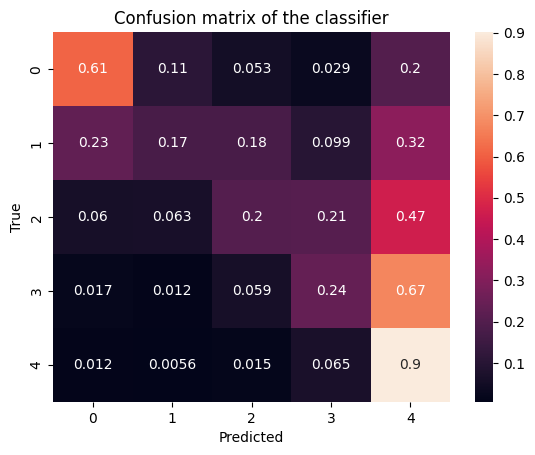

In [75]:
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [76]:
# Create the submission file
print(X_submission.shape)
submission['Score'] = lgb_model.predict(X_submission_select)
submission = submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)

(212192, 9)
